<h1>Implement Random Forest for Arbetrary Goalies</h1>
<p>This notebook looks at the random forest implementation for the selected goalie and calculates the increased risk factor for a current game as well as if they were to play the rest of the season</p>

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt, timedelta
from dateutil.relativedelta import *
import re
import sqlite3
pd.set_option('display.max_rows', 500)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load

<h3>SQLite Handling functions</h3>
<p>Use Pandas to import dataframe into SQLlite</p>

In [2]:
DB = "../assests/hockey_data_goalies.db"

#SQL Handle functions
def run_query(q):
    with sqlite3.connect(DB) as conn:
        x = pd.read_sql(q,conn)
    return x
   
#send command
def run_command(c):
    with sqlite3.connect(DB) as conn:
        conn.isolation_level = None
        return conn.execute(c)
    
#show tables
def show_tables():
    r = """
    Select name,type
    FROM sqlite_master
    WHERE type in ("table","view");
        """
    return run_query(r)

In [28]:
#ran_for = load('ranforest_regression.joblib')
ran_for = load('log_R.joblib')
pipe = load('pipeline.joblib')

In [29]:
def riskfunc(x):
    """Estimate the increased risk factor by player playing
    """
    y = x**3+0.37*(x**2)-0.2572*x+0.0118
    return np.round(10**y,1)

def risk(team_value,year_value,game_date,add_min=0):
    #add_min are the additional minutes

    #get unique ids
    q = ("""SELECT * 
        FROM player_log 
        WHERE team_id=\"{0}\"
        AND (CAST(SUBSTR(date_game,1,4) AS FLOAT)+CAST(SUBSTR(date_game,6,7) AS FLOAT)/12) > {1}
        AND date_game < \"{2}\"
        GROUP BY player_id
        """.format(team_value,int(year_value) + .66,game_date))

    ids = run_query(q)

    #now generate data for season

    prodf = pd.DataFrame(columns=['player_id','team_id','opp_id','date_game','age','rest_days','min_season',
                                    'shots_against','save_pct','min3W','sa3W','svepct3W','future_save_pct','injured'])
    row = 0
    for each_id in ids['player_id']:
        print(each_id)
        q = ("""SELECT * 
        FROM player_log 
        WHERE (CAST(SUBSTR(date_game,1,4) AS FLOAT)+CAST(SUBSTR(date_game,6,7) AS FLOAT)/12) > {0}
        AND date_game < \"{1}\"
        AND player_id = \"{2}\"
        """.format(int(year_value) + .66,game_date,each_id))
        season_logs = run_query(q)
        season_logs['date_game'] = season_logs['date_game'].astype('datetime64') #convert to datetime
        season_logs['time_on_ice'] = season_logs['time_on_ice'].str.extract(r'(\d*)\:\d*')[0].astype(int)+season_logs['time_on_ice'].str.extract(r'\d*\:(\d*)')[0].astype(int)/60

        for r,game in season_logs[-1:].iterrows():
            prodf.loc[row,'player_id'] = season_logs.loc[r,'player_id']
            prodf.loc[row,'team_id'] = season_logs.loc[r,'team_id']
            prodf.loc[row,'opp_id'] = season_logs.loc[r,'opp_id']
            prodf.loc[row,'date_game'] = season_logs.loc[r,'date_game']
            prodf.loc[row,'age'] = season_logs.loc[r,'age']
            prodf.loc[row,'rest_days'] = (season_logs.loc[r,'date_game']-season_logs.loc[r-1,'date_game']).days+add_min/15
            prodf.loc[row,'min_season'] = season_logs.loc[:(r-1),'time_on_ice'].sum()+add_min
            prodf.loc[row,'shots_against'] = season_logs.loc[:(r-1),'shots_against'].sum()
            prodf.loc[row,'save_pct'] = np.round(season_logs.loc[:(r-1),'saves'].sum()/season_logs.loc[:(r-1),'shots_against'].sum(),3)

            window = (season_logs.loc[r,'date_game']>season_logs['date_game'])&(season_logs['date_game']>(season_logs.loc[r,'date_game']-timedelta(21)))

            prodf.loc[row,'min3W'] = season_logs.loc[window,'time_on_ice'].sum()-add_min/5
            prodf.loc[row,'sa3W'] = season_logs.loc[window ,'shots_against'].sum()-add_min/2
            prodf.loc[row,'svepct3W'] = season_logs.loc[window,'saves'].sum()/season_logs.loc[window,'shots_against'].sum()
            prodf.loc[row,'injured'] = season_logs.loc[r,'injured']    
            prodf.loc[row,'pre_inj'] = season_logs.loc[r,'pre_inj']
        row+=1
    print(prodf['min_season'])
    columns = ['age','min_season','rest_days','shots_against','save_pct','min3W','sa3W','svepct3W','pre_inj']
    probs = ran_for.predict_proba(pipe.fit_transform(prodf[columns]))[:,1]
    riskfunc(probs)
    return dict(zip(ids['player_id'].to_list(),riskfunc(probs)))

def games_remaining(team_id,year_value,game_date):
    """Estimates the minutes remaining in the season (exluding overtimes)"""
    #get all the games for the team that season
    q = ("""SELECT * 
        FROM team_log 
        WHERE (CAST(SUBSTR(date_game,1,4) AS FLOAT)+CAST(SUBSTR(date_game,6,7) AS FLOAT)/12) < {0}
        AND date_game >=  \"{1}\"
        AND team_id = \"{2}\"
        """.format(int(year_value) + 1.66,game_date,team_id))
    team_logs = run_query(q)
    
    return team_logs.shape[0]*60,team_logs

In [30]:
#calculate the risk factor
risk('TOR','2016','2017-01-17',0)

anderfr01
enrotjh01
mcelhcu01
0    1966.03
1    214.433
2    375.917
Name: min_season, dtype: object


{'anderfr01': 2.2, 'enrotjh01': 1.0, 'mcelhcu01': 1.2}

In [31]:
#estimate the remaining games in the season
a,b = games_remaining('TOR','2016','2017-01-17')

In [32]:
injury_risk = pd.DataFrame(columns = ['anderfr01','enrotjh01','mcelhcu01'])
for i,r in b.iterrows():
    #calculate the risk factor
    m = risk('TOR','2016',r['date_game'])
    injury_risk = injury_risk.append(m,ignore_index=True)

anderfr01
enrotjh01
mcelhcu01
0    1966.03
1    214.433
2    375.917
Name: min_season, dtype: object
anderfr01
enrotjh01
mcelhcu01
0    2025.85
1    214.433
2    375.917
Name: min_season, dtype: object
anderfr01
enrotjh01
mcelhcu01
0    2085.85
1    214.433
2    375.917
Name: min_season, dtype: object
anderfr01
enrotjh01
mcelhcu01
0    2145.43
1    214.433
2    375.917
Name: min_season, dtype: object
anderfr01
enrotjh01
mcelhcu01
0    2210.43
1    214.433
2    375.917
Name: min_season, dtype: object
anderfr01
enrotjh01
mcelhcu01
0    2270.43
1    214.433
2    375.917
Name: min_season, dtype: object
anderfr01
enrotjh01
mcelhcu01
0    2270.43
1    214.433
2    435.917
Name: min_season, dtype: object
anderfr01
enrotjh01
mcelhcu01
0    2330.43
1    214.433
2    494.267
Name: min_season, dtype: object
anderfr01
enrotjh01
mcelhcu01
0    2341.63
1    214.433
2    494.267
Name: min_season, dtype: object
anderfr01
enrotjh01
mcelhcu01
0    2401.63
1    214.433
2    494.267
Name: min_season, dtyp

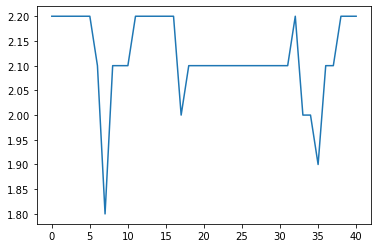

In [34]:
import matplotlib.pyplot as plt

plt.plot(injury_risk.index,injury_risk[injury_risk.columns[0]],label=injury_risk.columns[0])
plt.show()

In [21]:
columns = ['age','min_season','rest_days','shots_against','save_pct','min3W','sa3W','svepct3W','pre_inj']
ran_for.feature_importances_

array([0.13200877, 0.10925019, 0.05489077, 0.1066287 , 0.10502206,
       0.11292687, 0.10666427, 0.10952352, 0.16308486])